In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import json
from scipy.interpolate import interp1d, interp2d

In [8]:
def plotcdf(array, plot=1, bins=50):
    ccdf, X, _ = plt.hist(array, bins = bins, density=True, log=True, cumulative=-1, histtype='step')
    ccdf = np.append(ccdf * 100, 0)
    plt.clf()
    plt.grid(True, which="both")
    plt.semilogy(X, ccdf, label='CCDF')
    plt.legend(loc='best')
    plt.xlabel('IWV (mm)')
    plt.ylabel('Probabilidad (%)')
    plt.title('CCDF')
    plt.show() if plot == 1 else plt.clf()
    return X, ccdf

In [9]:
def interp_list(x, y, new_x):
    new_y = []
    y_interp = interp1d(x, y, kind='linear')
    new_y = np.array([float(y_interp(val)) for val in new_x])
    return new_y

In [36]:
wat_file = pd.read_csv('ITUFiles/wat676.csv')
oxy_file = pd.read_csv('ITUFiles/oxy676.csv')
fw = wat_file['fw'].to_numpy()
b1 = wat_file['b1'].to_numpy()
b2 = wat_file['b2'].to_numpy()
b3 = wat_file['b3'].to_numpy()
b4 = wat_file['b4'].to_numpy()
b5 = wat_file['b5'].to_numpy()
b6 = wat_file['b6'].to_numpy()
fo = oxy_file['fo'].to_numpy()
a1 = oxy_file['a1'].to_numpy()
a2 = oxy_file['a2'].to_numpy()
a3 = oxy_file['a3'].to_numpy()
a4 = oxy_file['a4'].to_numpy()
a5 = oxy_file['a5'].to_numpy()
a6 = oxy_file['a6'].to_numpy()

In [37]:
def itu676(f, p, rho, T):
    # p: dry air presure (hPa)
    # e: water vapour partial pressure (hPa)
    # T: Temperature (K)
    theta = 300/T
    e = (rho*T)/216.7
    So = a1 * (1e-7) * p * (theta**3) * np.exp(a2 * (1 - theta))
    Sw = b1 * (1e-1) * e * (theta**3.5) * np.exp(b2 * (1 - theta))
    deltao = (a5 + a6 * theta) * (1e-4) * (p + e) * (theta**0.8)
    deltaw = 0
    deltafo_wd = a3 * (1e-4) * (p * (theta**(0.8 - a4)) + 1.1 * e * theta)
    deltafw_wd = b3 * (1e-4) * (p * (theta**b4) + b5 * e * (theta**b6))
    deltafo = np.sqrt(deltafo_wd**2 + 2.25e-6)
    deltafw = 0.535 * deltafw_wd + np.sqrt((0.217 * deltafw_wd**2) + (2.1316e-12 * (fw**2))/(theta))
    Fo = ((f)/(fo)) * (((deltafo - deltao * (fo - f))/(deltafo**2 + (fo - f)**2))+((deltafo - deltao * (fo + f))/(deltafo**2 + (fo + f)**2)))
    Fw = ((f)/(fw)) * (((deltafw - deltaw * (fw - f))/(deltafw**2 + (fw - f)**2))+((deltafw - deltaw * (fw + f))/(deltafw**2 + (fw + f)**2)))
    d = (5.6e-4) * (p + e) * (theta**0.8)
    N2Df = f * p * theta**2 * (((6.14e-5)/(d * (1+(f/d)**2)))+((1.4e-12 * p * theta**1.5)/(1 + 1.9e-5 * f**1.5)))
    N2f = sum(Fo * So) + sum(Fw * Sw) + N2Df
    y = 0.182 * f * N2f
    ywv = 0.182 * f * sum(Fw * Sw)
    yox = 0.182 * f * (sum(Fo * So) + N2Df)
    return y, ywv, yox

In [10]:
prob_nom = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 60, 70, 80, 90, 95, 99]

### El Alto

Data Loading
 - d --> 2 meter dewpoint temperature (K)
 - T --> 2 meter temperature (K)
 - P --> Surface Pressure (Pa)

In [24]:
time = '00'
param = ['2d_', '2t_', 'sp_']
param = [x + time + '.txt' for x in param]
param

['2d_00.txt', '2t_00.txt', 'sp_00.txt']

In [25]:
def get_dtp(path, time):
    param = ['2d_', '2t_', 'sp_']
    param = [x + time + '.txt' for x in param]
    d = pd.read_csv(path + param[0], header=None, sep='\n').to_numpy()
    T = pd.read_csv(path + param[1], header=None, sep='\n').to_numpy()
    P = pd.read_csv(path + param[2], header=None, sep='\n').to_numpy()
    dfindex = ['Probabilities', '2D', '2T', 'SP']
    dX, dccdf = plotcdf(d, 0, 100)
    dXn = interp_list(dccdf, dX, prob_nom)
    TX, Tccdf = plotcdf(T, 0, 100)
    TXn = interp_list(Tccdf, TX, prob_nom)
    PX, Pccdf = plotcdf(P, 0, 100)
    PXn = interp_list(Pccdf, PX, prob_nom)
    results = pd.DataFrame(np.column_stack([prob_nom, dXn, TXn, PXn]), columns=dfindex)
    outputname = path + 'CCDF_DTP_' + time + '.csv'
    results.to_csv(outputname, index=False)
get_dtp('OAttenuation/DailyData/ElAlto/', '00')

<Figure size 432x288 with 0 Axes>

### get_pe()
Input dptemp (K) temp (K) pre (Pa) <br/>
Output p (dry air pressure (hPa)) and e (water vapour partial pressure (hPa))

In [33]:
def get_pep(dptemp, temp, pre):
    pre = pre / 100
    dptemp = dptemp - 273.15
    temp = temp - 273.15
    a = 6.1121
    b = 18.678
    c = 257.14
    d = 234.5
    aux1 = (c * (b * d + c)) / (d * (temp + c))
    aux2 = temp / d
    aux3 = (-b * c) / (c + dptemp)
    aux4 = - c / d
    rh = 100 * np.exp(aux1 + aux2 + aux3 + aux4)
    ef = 1 + (10 ** -4) * (7.2 + pre * (0.0320 + 5.9 * (10 ** -6) * (temp ** 2)))
    es = ef * a * np.exp((temp * (b - temp / d))/(temp + c))
    e = rh * es / 100 # Water vapour partial pressure (hPa)
    rho = e * 216.7 / temp # Absolute Humidity
    p = pre - e # Dry Air Pressure
    return p, e, temp, rho

In [34]:
df = pd.read_csv('OAttenuation/DailyData/ElAlto/CCDF_DTP_00.csv')
twod = df['2D'].to_numpy()
twot = df['2T'].to_numpy()
P = df['SP'].to_numpy()
p, e, T, rho = get_pep(twod, twot, P)

In [41]:
def calc_yox(f, p, rho, T):
    yox = []
    T = T + 273.15
    for i in range(len(p)):
        aux = itu676(f, p[i], rho[i], T[i])[2]
        yox.append(aux)
    return np.array(yox)
yox = calc_yox(20, p, rho ,T)

In [47]:
def get_ho(f, p, e, T):
    ci = np.array([0.1597, 0.1066, 0.1325, 0.1242, 0.0938, 0.1448, 0.1374])
    fi = np.array([118.750334, 368.498246, 424.76302, 487.249273, 715.392902, 773.83949, 834.145546])
    rp = (p + e) / 1013.25
    t3 = (0.0114 * f)/(1 + 0.14 * (rp ** -2.6)) * (15.02 * f * f - 1353 * f + 5.333e4)/((f ** 3)- 151.3 * f * f + 9629 * f - 6803)
    t1 = (5.104 / (1 + 0.066 * rp ** -2.3)) * np.exp(-((f - 59.7)/(2.87 + 12.4 * np.exp(-7.9 * rp))) ** 2)
    t2 = np.sum((ci * np.exp(2.12 * rp))/((f - fi) ** 2 + 0.025 * np.exp(2.2 * rp)))
    A = 0.7832 + 0.00709 * T
    ho = (6.1 * A * (1 + t1 + t2 + t3)) / (1 + 0.17 * rp ** -1.1)
    return ho
def calc_ho(f, p, e, T):
    ho = []
    for i in range(len(p)):
        aux = get_ho(f, p[i], e[i], T[i])
        ho.append(aux)
    return np.array(ho)
ho = calc_ho(20, p, e, T)

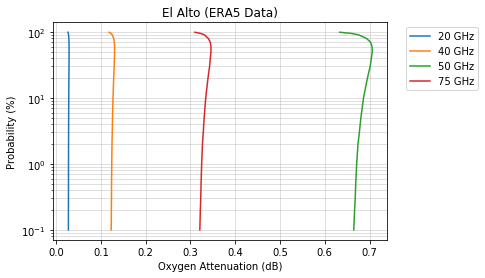

In [50]:
yox = calc_yox(20, p, rho ,T)
ho = calc_ho(20, p, e, T)
oxat_20 = yox * ho
yox = calc_yox(40, p, rho ,T)
ho = calc_ho(40, p, e, T)
oxat_40 = yox * ho
yox = calc_yox(50, p, rho ,T)
ho = calc_ho(50, p, e, T)
oxat_50 = yox * ho
yox = calc_yox(75, p, rho ,T)
ho = calc_ho(75, p, e, T)
oxat_75 = yox * ho
plt.semilogy(oxat_20, prob_nom, label='20 GHz')
plt.semilogy(oxat_40, prob_nom, label='40 GHz')
plt.semilogy(oxat_50, prob_nom, label='50 GHz')
plt.semilogy(oxat_75, prob_nom, label='75 GHz')
plt.grid(True, which="both", alpha=0.5)
plt.title('El Alto (ERA5 Data)')
plt.xlabel('Oxygen Attenuation (dB)')
plt.ylabel('Probability (%)')
plt.legend(bbox_to_anchor=(1.04,1), loc='best')
plt.show()